___
**Student Name:** Chelashaw, Joshua

**Student ID:** 24481208
___

### Import Statements

In [1]:
# Import statements
import numpy as np
import pandas as pd
import apmodule as ap
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 10 
plt.rcParams['lines.linewidth'] = 3
%matplotlib inline
from matplotlib.ticker import FuncFormatter


### Define custom functions

The following are the functions used throughout the report. To enhance readability, they are all defined here and referenced throughout the notebook when needed.

In [2]:
'''This function calls the ic_analysis module, and for each factor inside the iterable list
prints out the annual ic information and also plots it in a bar graph, ensuring to change the index 
appropriately'''
def annual_ic_plot(factors, prices):
    for factor in factors:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        print(f'{factor.name} Annual IC Analysis Information:\n') 
        analysis_result = ap.ic_analysis(factor, prices, frequency='annual')

        print(f'{factor.name} Graph:\n')
        analysis_result.index = analysis_result.index.year + 1 
        analysis_result.plot(kind='bar', ax=ax)  # Plot the ic analysis result
        ax.set_title('Information Coeffiecient of the ' + factor.name + ' factor.')

        plt.tight_layout()
        plt.show()
        print('\n')

'''Function to enhance readability when displaying various rebalancing 
configurations for portfolio optimisaiton'''
def which_frequency(num):
    if num == 1:
        return 'Monthly'
    elif num == 3:
        return 'Quaterly'
    elif num == 6:
        return 'Semi-Annually'
    elif num == 12:
        return 'Annually'
    else:
        return 'Undefined frequency'
    
#Calculates and plots the average information coefficient on a specified frequency
def avg_ic_plot(ic, freq):
    mean_values = ic.mean() 

    # Plot the bar chart
    fig, ax = plt.subplots(figsize=(10, 6))

    bars = ax.bar(mean_values.index, mean_values.values, color='darkblue', edgecolor='grey')

    # Set the titles and axis labels
    ax.set_ylabel('Information Coefficient')
    ax.set_xlabel('Factors')
    ax.set_title(f'Average {freq} Information Coefficient')

    # Set the y-axis limit dynamically
    y_maxlimit = mean_values.max() + 0.05
    y_minlimit = min(0, mean_values.min() - 0.05)    

    ax.set_ylim(y_minlimit, y_maxlimit) 

    #Make the plot's appearance cleaner
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))
    ax.spines['right'].set_visible(False)
    ax.yaxis.grid(True, linestyle='--', alpha=1)

    # Rotate x-axis labels
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        tick.set_horizontalalignment('right')

    # Add IC value as labels on top of the bars
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    # Show the plot
    plt.tight_layout()
    plt.show()

#The ic analysis with no printout for enhanced readability
def ic(signal, prices, frequency):
    
    #We load all the modules needed in the function just in case they are not loaded in the notebook.
    #They are only active within the function, if you need them elsewhere in the notebook you need to 
    #import them again in the notebook
    import pandas as pd
    import numpy as np
    from scipy import stats
    
    #We check that the frequency is correct. If not we stop the function and return an empty result
    if frequency not in ['monthly', 'quarterly', 'annual']:
        print('Warning, the frequency must be monthly, quarterly or annual')
        return None
    
    #We capture the name of the factor using the .name attribute to use it later
    signal_name = signal.name
    
    #We calculate the returns according to the periodicity chosen in the input
    if frequency=='monthly':
        future_returns = np.log(prices.groupby('id').shift(-1) / prices).rename('fut_ret')
        
    elif frequency=='quarterly':
        future_returns = np.log(prices.groupby('id').shift(-3) / prices).rename('fut_ret')
        
    elif frequency=='annual':
        future_returns = np.log(prices.groupby('id').shift(-12) / prices).rename('fut_ret')
    
        
    #We join the signal with the future return
    data = signal.to_frame().join(future_returns).dropna()
    data['month'] = data.index.get_level_values('date').month
    
    #We select the relevant months for the annual or quarterly analysis
    if frequency=='annual':
        data = data[data['month']==12]
        
    elif frequency=='quarterly':
        data = data[data['month'].isin([3, 6, 9, 12])] #.isin() checks if the number is among the ones in the list
    
    #We drop the month column because we do not need it anymore
    data.drop(columns=['month'], inplace=True)
    
    #We calculate the IC
    ic = data.groupby('date').corr(method='spearman').iloc[0::2,-1].droplevel(level=1).rename('IC')
    
    #We print on screen the average IC
    # print('Average IC:', round(ic.mean(), 3), '\n')
    
    #We calculate and print the percentage of positive/negative observations
    sign = np.sign(ic).value_counts() / ic.count()
    
    # print('Percentage of Positive Periods:', round(sign.loc[1], 3), '\n')
    # print('Percentage of Negative Periods:', round(sign.loc[-1], 3), '\n')
    
    #We calculate and print the t-test
    t_test = stats.ttest_1samp(ic, 0)
    # print(f'T-Stat: {round(t_test.statistic,3)} P-Value: {round(t_test.pvalue,3)} \n')
    
    #We return the series with the Information Coefficient for further analysis using the original name of the factor
    return ic.rename('ic_' + signal_name)


### Load the data

In [3]:
#Loading the monthly data of our new investment factors
#Interest Coverage Ratio
int_cov = pd.read_csv('INTCOV.zip', parse_dates=['date']).set_index(['id', 'date']).squeeze().rename('Interest Coverage Ratio')

#Cash flow to Debt Ratio
cash_debt = pd.read_csv('CASH_DEBT.zip', parse_dates=['date']).set_index(['id', 'date']).squeeze().rename('Cash flow to Debt Ratio')

# Cash flow to current liabilities Ratio
cf_cl = pd.read_csv('OCF_LCT.zip', parse_dates=['date']).set_index(['id', 'date']).squeeze().rename('Cash flow to Current Liabilities Ratio')


#Loading the monthly data of traditional investment factors
#Quarterly Earnings to Price
epq = pd.read_csv('EPQ.zip', parse_dates=['date']).set_index(['id', 'date']).squeeze().rename('Value')

#Gross Profitability
gp = pd.read_csv('GP.zip', parse_dates=['date']).set_index(['id', 'date']).squeeze().rename('Profitability')

#Total Volatility
tvol = pd.read_csv('TVOL.zip', parse_dates=['date']).set_index(['id', 'date']).squeeze().rename('Low Volatility')

#12 Month Momentum
mom12 = pd.read_csv('MOM12.zip', parse_dates=['date']).set_index(['id', 'date']).squeeze().rename('Momentum')


#Non-factor data
#Monthly time series for 10 and 1 year yield to maturity of US Government Bonds
int_rates = pd.read_csv('INT_RATES.csv', parse_dates=['date']).set_index(['date'])

#Monthly market capitalization for US companies from 1980
market_cap = pd.read_csv('Market_cap.zip', parse_dates=['date']).set_index(['id', 'date'])

#The name and industry affiliation for all US companies
names = pd.read_csv('names.zip').set_index(['id'])

#Monthly (adjusted) prices for US companies from 1980
prices = pd.read_csv('Prices.zip', parse_dates=['date']).set_index(['id', 'date']).squeeze()

# **1. Statistical Analysis**

This section completes statistical analysis of the predictive power of these three financial ratios:
- Interest Coverage Ratio | (int_cov)
- Cash flow to Current Liabilities Ratio | (cf_cl)
- Cash flow to Debt Ratio | (cash_debt)

The analysis is based on the Information Coefficient.

A synthetic 'Average' factor is also analysed. This factor is built as the average of the three factors above.

The average IC shows the strength of the predicitve powers over the entire sample.
The graphs show how the predictive power changes each year between 1980 and 2023.

Create the synthetic factor:

In [4]:
#Creating a synthetic factor of all three ratios calculated as the average of the three

#Create a dictionary from the series of the factors
new_factors_dict = {'Interest Coverage Ratio': int_cov, 'Cash Flow to Current Liability Ratio': cf_cl, 'Cash Flow to Debt Ratio': cash_debt}

#Create a Dataframe from the dictionary and drop all the NAN values
new_factors = pd.DataFrame(new_factors_dict).dropna()

#Make the new column with all of the average of the three ratios and name it the Synthetic Factor
# new_factors['Synthetic (AVG) Ratio'] = new_factors[['Interest Coverage Ratio', 'Cash Flow to Current Liability Ratio', 'Cash Flow to Debt Ratio']].mean(axis=1)

#Compute the mean across all columns in the DataFrame
new_factors['Synthetic (AVG) Ratio'] = new_factors.mean(axis=1)

#Make a new series with only the synthetic factor
synthetic = new_factors[['Synthetic (AVG) Ratio']].squeeze().rename('Synthetic')

Each factors information coefficient is analysed at a monthly level.

A graph of the monthly IC is plotted, with a rolling 12 month mean to display longer horizon results.

Interest Coverage Ratio - monthly IC Analysis info:

Average IC: 0.064 

Percentage of Positive Periods: 0.771 

Percentage of Negative Periods: 0.229 

T-Stat: 14.717 P-Value: 0.0 

Interest Coverage Ratio IC Graph:



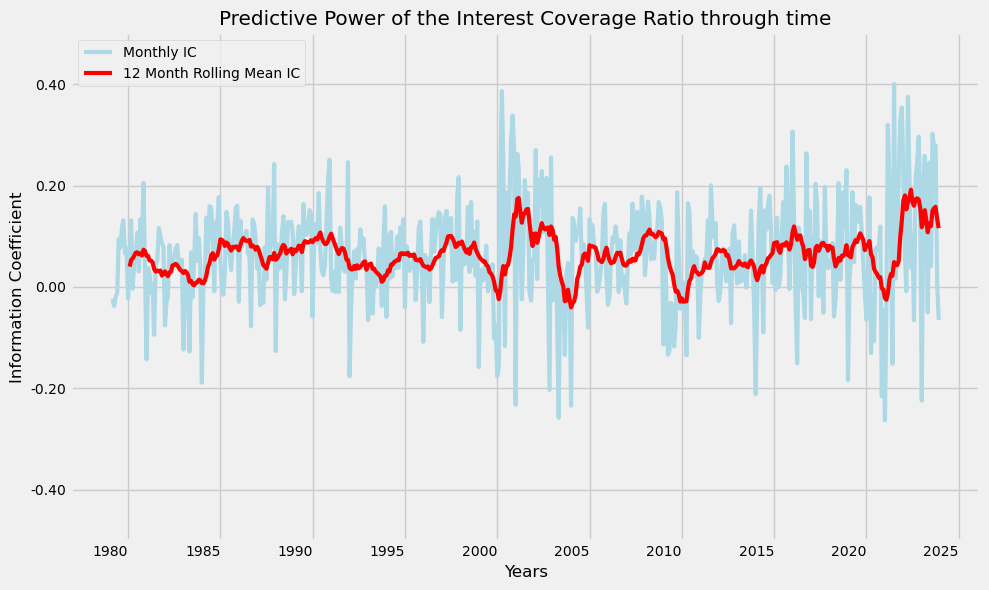



Cash Flow to Current Liability Ratio - monthly IC Analysis info:

Average IC: 0.073 

Percentage of Positive Periods: 0.79 

Percentage of Negative Periods: 0.21 

T-Stat: 17.325 P-Value: 0.0 

Cash Flow to Current Liability Ratio IC Graph:



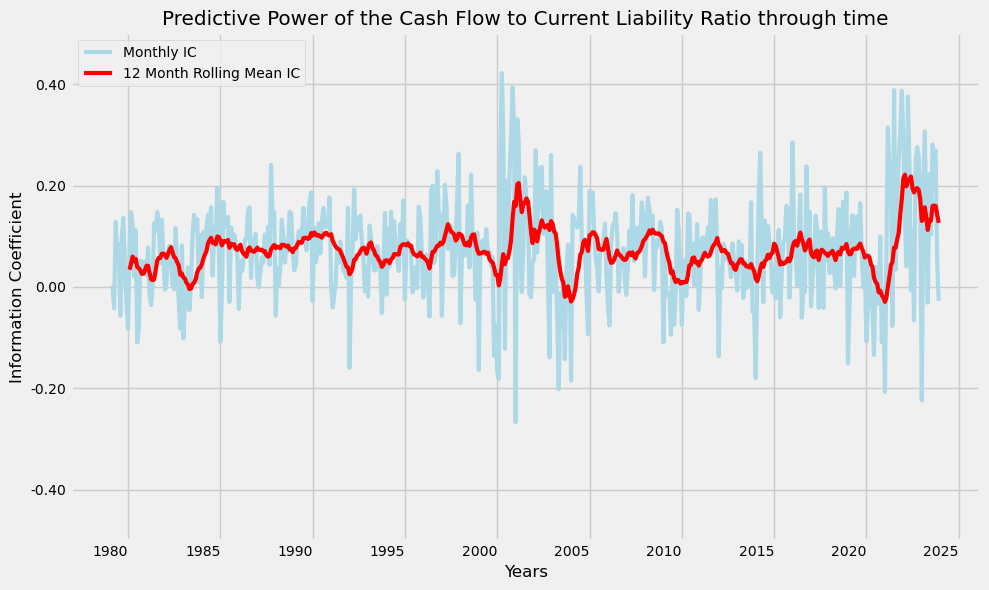



Cash Flow to Debt Ratio - monthly IC Analysis info:

Average IC: 0.066 

Percentage of Positive Periods: 0.816 

Percentage of Negative Periods: 0.184 

T-Stat: 17.367 P-Value: 0.0 

Cash Flow to Debt Ratio IC Graph:



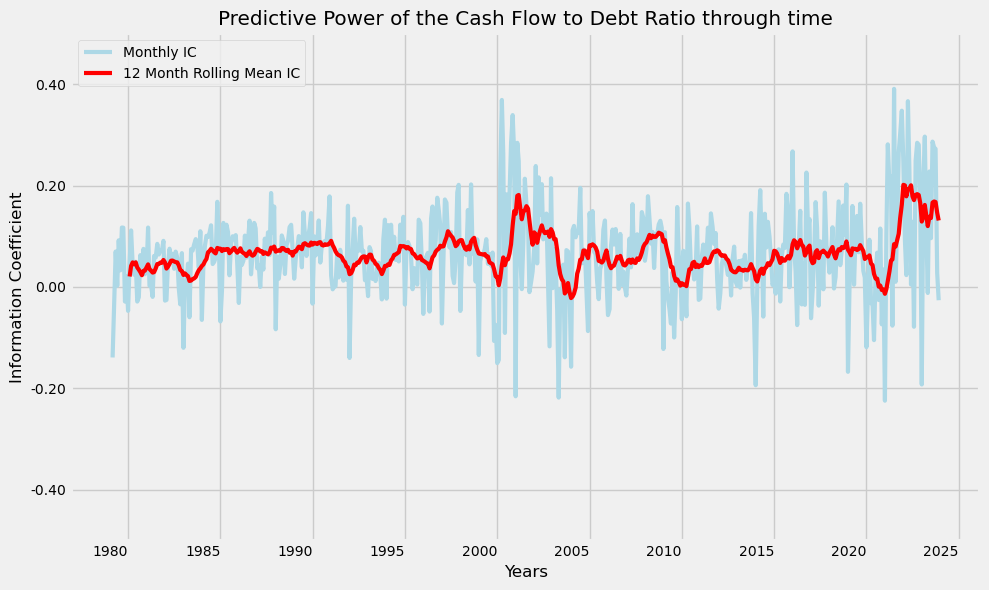



Synthetic (AVG) Ratio - monthly IC Analysis info:

Average IC: 0.072 

Percentage of Positive Periods: 0.799 

Percentage of Negative Periods: 0.201 

T-Stat: 17.306 P-Value: 0.0 

Synthetic (AVG) Ratio IC Graph:



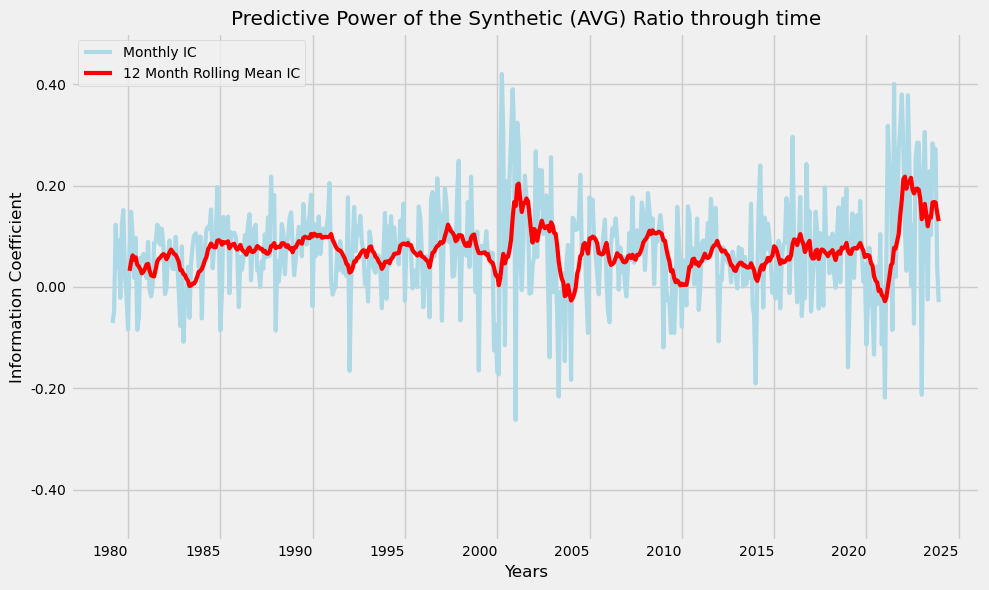

In [5]:
# Create an empty DataFrame to store analysis results
ar = pd.DataFrame()

# Loop through each column in the new_factors dataframe
for c in new_factors.columns:
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    print(f'{new_factors[c].name} - monthly IC Analysis info:\n') 

    # Perform IC analysis on the current factor using the 'ap.ic_analysis()' function
    # This function outputs the analysis information
    analysis_result = ap.ic_analysis(new_factors[c], prices, frequency='monthly')

    # Save the result from the ic_analysis function into the DataFrame 'ar' for further analysis
    ar[f'{new_factors[c].name}'] = analysis_result

    print(f'{new_factors[c].name} IC Graph:\n')
    # Plot the Monthly IC graph for the current factor
    ar[c].rename(f'Monthly IC').plot(ax=ax, color='lightblue')
    # Plot the 12-month rolling mean of the IC graph
    ar[c].rolling(12).mean().rename('12 Month Rolling Mean IC').plot(ax=ax, color='red', rot=0)
    
    # Set the y-axis limits
    ax.set_ylim(-0.5, 0.5)

    # Customize the y-axis to show 2 decimal places
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))

    #Format and display the graph
    ax.set_ylabel('Information Coefficient')
    ax.set_xlabel('Years')
    ax.set_title('Predictive Power of the ' + new_factors[c].name + ' through time')
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()
    print('\n')

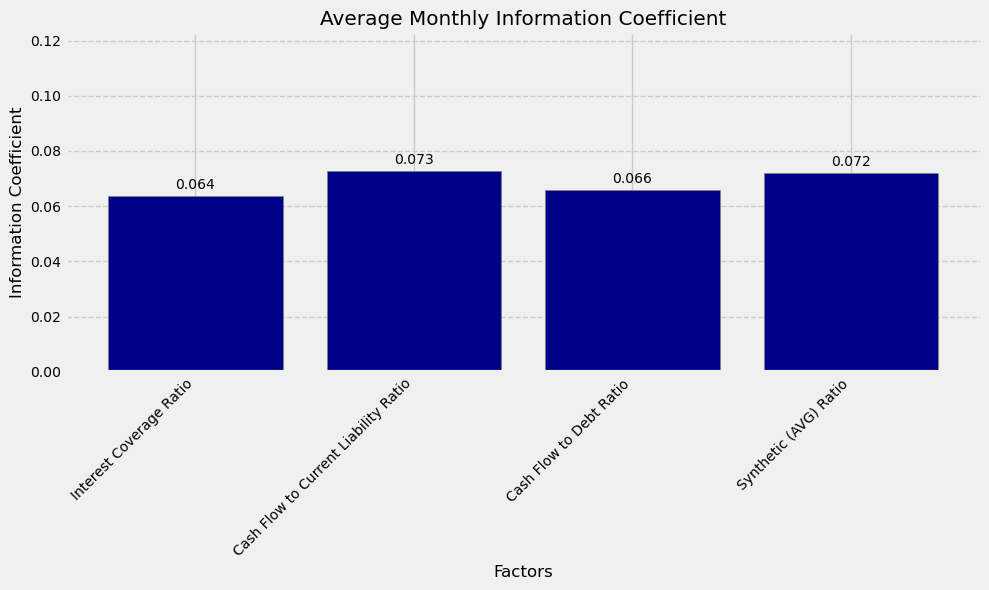

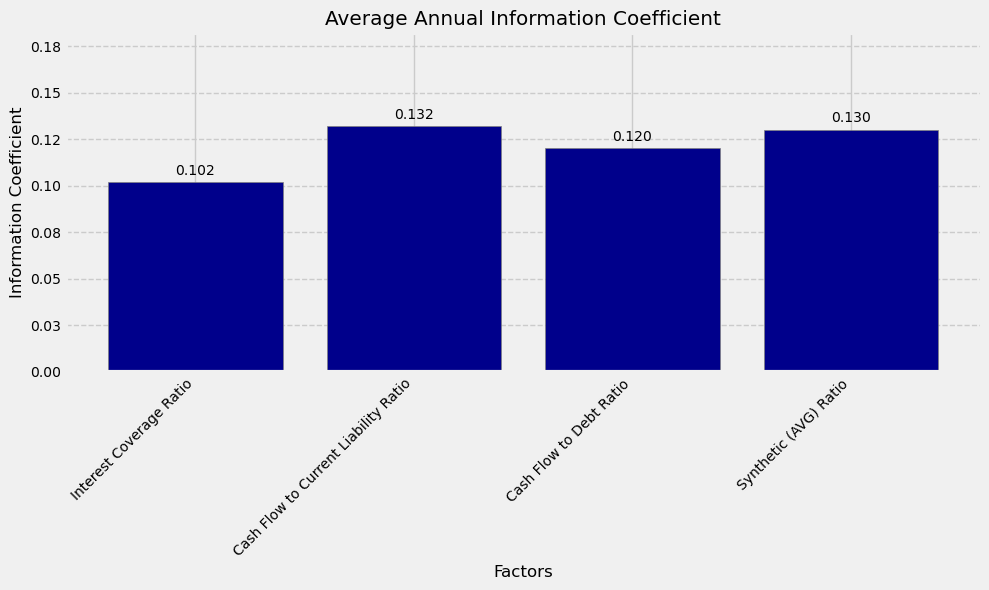

In [6]:
#Plot the strength for the monthly IC
avg_ic_plot(ar, 'Monthly')

#Calculate the annual IC for each of the new factors
annual_ic = pd.DataFrame()
for c in new_factors.columns:
    annual_ic[f'{new_factors[c].name}'] = ic(new_factors[c], prices, frequency='annual')

#Plot the strength for the annual IC
avg_ic_plot(annual_ic, 'Annual')

# **2. Backtesting**

Create and backtest a long-short 130/30 strategy based on the Synthetic (“Average”) factor.

The strategy includes the following:
- Overinvestment in the top 300 stocks and underinvestment in the bottom 300.
- An active percentage of 30%
- Tested between 2007 and 2023.
- Rebalances monthly.
- Assumes an 0.2% roundtrip of transaction costs.

Rank the stocks by market capitalisation and retain only the top 1500 to enhance the validity of the backtesting, ensuring that it does not assume all stocks can be short sold.

In [7]:
#Join the factor and market cap into a new dataframe
df = synthetic.to_frame().join(market_cap)

#Rank the sample, grouped by the dates
df['rank'] = df.groupby('date')['market_cap'].rank(ascending=False, method='min')

#Select the stocks where the ranking is smaller than and/or equal to 1500
df = df[df['rank']<=1500]

#Save this into a new series
syn_factor = df['Synthetic']

Build the long short strategy and complete the backtesing, using our ranked synthetic factor.

In [8]:
syn_return, syn_turnover, syn_comp, syn_perf = ap.ls_backtesting(syn_factor, prices, market_cap, 
                                                      start='2007-01-01', end='2023-12-31',
                                                      frequency=1, t_cost=0.002, N=300, active=0.3)

Highlight the performance of the portfolio, formatting the output from the backtesting function.

In [9]:
syn_perf_copy = syn_perf

# Convert to percentages where applicable
percentage_columns = syn_perf_copy.index.difference(['RR Ratio'])
syn_perf_copy.loc[percentage_columns] = syn_perf_copy.loc[percentage_columns] * 100

# Round to 2 decimal places
syn_perf_copy = syn_perf_copy.round(2)

# Format as string with percentage symbol
syn_perf_copy.loc[percentage_columns] = syn_perf_copy.loc[percentage_columns].astype(str) + '%'

# Display the dataframe
syn_perf_copy

,LS Portfolio,Benchmark,LS Active
Mean Return,10.13%,6.92%,3.21%
St. Dev.,14.84%,15.94%,3.73%
RR Ratio,0.68,0.43,0.86
% Positive,66.18%,64.22%,58.82%
Worst Month,-15.08%,-18.87%,-2.48%
Best Month,12.79%,12.77%,3.93%
Max DrawDown,-51.36%,-59.86%,-7.4%


Plot the cumuliative returns assuming an initial investment of $1.

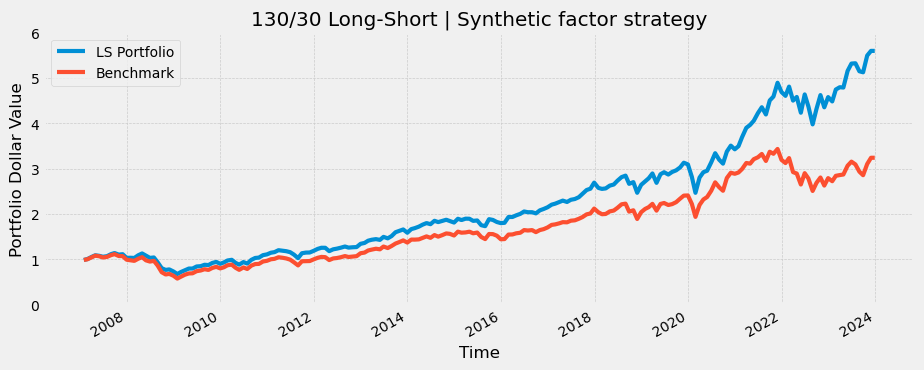

In [10]:
#Store the values, dropping the 'active' column for better visualisation
monthly_ret = syn_return.drop(columns='LS Active')

#Calculate cumulative return from our logarithmic return values
return_values = monthly_ret.cumsum().apply(np.exp)

#Plot the data
fig, ax = plt.subplots(figsize=(10, 4))
return_values.plot(ax=ax)

#Customize the grid for a cleaner look
ax.grid(True, which='major', linestyle='--', linewidth=0.5)
ax.grid(True, which='minor', linestyle='', linewidth=0.5)
ax.minorticks_on()

#Set titles and labels
ax.set_title('130/30 Long-Short | Synthetic factor strategy')
ax.set_ylabel('Portfolio Dollar Value')
ax.set_xlabel('Time')
ax.set_ylim(0, 6)

#Display the plot
plt.show()

In [11]:
syn_perf

,LS Portfolio,Benchmark,LS Active
Mean Return,10.132479,6.917887,3.214592
St. Dev.,14.835441,15.940248,3.733712
RR Ratio,0.682991,0.433989,0.860964
% Positive,66.176471,64.215686,58.823529
Worst Month,-15.081328,-18.874051,-2.478568
Best Month,12.786921,12.770614,3.933937
Max DrawDown,-51.358525,-59.859458,-7.401046


In [12]:
final_val = return_values['LS Portfolio'].iloc[-1]
print(f'Final cumulative value: ${round(final_val, 2)}')

Final cumulative value: $5.6


# **3. Optimisation**

Finding the optimal parameters of the strategy in order to maximize the performance.
Focusing on the number of shares to over-under-weight and on the rebalancing
frequency.

When performing backtests for the strategy optimisaiton, we use the same time period and transaction costs as above.

Define the variables to test:

In [13]:
share_num = [50, 100, 500]

rebalancing_freq = [3,6,12] 

Complete the backtesting of each combination within a double nested loop 

In [14]:
#Create an empty dataframe to store the portfolio returns into
rets = pd.DataFrame()

#Create an empty dataframe to store the portfolio performance into
perfs = pd.DataFrame()
i=0

#Loop testing each type of share number with each rebalancing frequency
for num in share_num:
    for freq in rebalancing_freq:
        i += 1 #Use this to display the version number for easier tracking

        optimal_ret, optimal_turnover, optimal_comp, optimal_perf = ap.ls_backtesting(syn_factor, prices, market_cap, 
                                                              start='2007-01-01', end='2023-12-31',
                                                              frequency=freq, t_cost=0.002, N=num, active=0.3)
        
        #Store the data in the version, with clear names to understand which returns or performance the data represents
        rets[f'V{i}:  {num} Shares, Rebalancing {which_frequency(freq)}.'] = optimal_ret['LS Portfolio']
        perfs[f'V{i}:  {num} Shares, Rebalancing {which_frequency(freq)}.'] = optimal_perf['LS Portfolio']

#Please note: This notebook cell takes 10-15s to run successfully and is optimised for functionality rather than speed

Add the original portfolio for quick performance comparisons

In [15]:
perfs['Original Portfolio'] = syn_perf['LS Portfolio'] / 100

Create an interactive, mean return graph using the plotly library

In [16]:
import plotly.graph_objects as go

#Assuming 'perfs' DataFrame is already defined and 'Mean Return' is correctly calculated

avg_returns = perfs.loc['Mean Return']

portfolios = avg_returns.index
returns = avg_returns.values

#Creating a colour list for the bars
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

#Creating the bar plot using plotly
fig = go.Figure()

#Adding bars to the figure
for i, portfolio in enumerate(portfolios):
    fig.add_trace(go.Bar(
        x=[portfolio],
        y=[returns[i]],  #Ensure returns are correct
        text=f'{returns[i]*100:.2f}%',  #Displaying the percentage as text
        textposition='outside',
        marker_color=colors[i % len(colors)],  #Ensuring colours cycle if there are more portfolios than colours
        name=portfolio
    ))

#Adding title and labels
fig.update_layout(
    title='Performance by Portfolio Variation',
    yaxis_title='Mean Return',
    xaxis_tickangle=-45,
    xaxis_tickfont_size=10,
    yaxis_tickfont_size=10,
    yaxis_tickformat='.2%',  #Formatting the y-axis as percentage
    legend_title='Portfolios:',
    plot_bgcolor='rgba(0,0,0,0)',
    bargap=0.2
)

#Remove all text from the x-axis
fig.update_xaxes(showticklabels=False)

#Display the plot
fig.show()

Compare the cumulative return for each portfolio variation if you invested $1 in 2007 to 2023

In [17]:
#Join the original backtested portfolio for easy comparison
rets = syn_return['LS Portfolio'].rename('Original Portfolio').to_frame().join(rets)

#Calculate the cumulative value if $1 was invested
port_values = rets.cumsum().apply(np.exp)

In [18]:
fig = px.line(port_values)

# Customize the layout
fig.update_layout(
    legend_title_text='Legend:',
    yaxis_title='Portfolio Dollar Value',
    xaxis_title='Years',
    xaxis=dict(
        tickmode='array',
        tickvals=[port_values.index[i] for i in range(0, len(port_values.index), 24)],  # 24 months = 2 years
        ticktext=[port_values.index[i].year for i in range(0, len(port_values.index), 24)]
    )
)

fig.show()

# **4. Black Belt** - Addressing the CIOs Concerns

### First Concern: 
Are these “new” investment factors or just a different way of measuring older factors?

Complete correlation analysis all the factors:

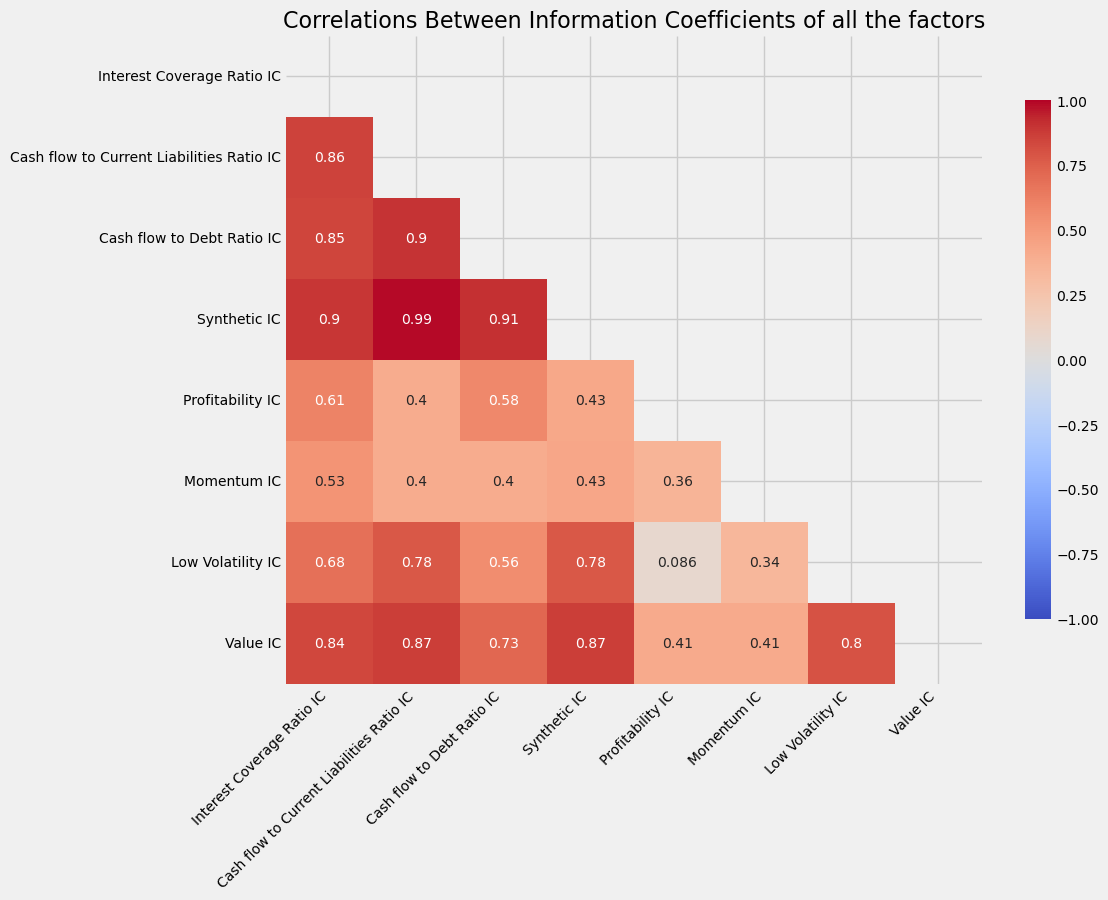

In [20]:
#Load in new factors
factors = [int_cov, cf_cl, cash_debt, synthetic, gp, mom12, tvol, epq]

tot_factors = pd.DataFrame()

#Calculate IC
for f in factors:
    tot_factors[f'{f.name} IC'] = ic(f, prices=prices, frequency='monthly')
    
#Calculate the correlations
corr = tot_factors.corr()

#Create a mask to display only the lower triangle of the correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool))

#Create the correlation heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(corr, annot=True, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={"shrink": .8})

#Adjust x and y ticks
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

plt.title('Correlations Between Information Coefficients of all the factors', fontsize=16)
plt.show()

Compute the Principle Component Analysis:

In [21]:
# Standardize the data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(tot_factors.dropna())

# Perform PCA
pca = PCA()
principal_components = pca.fit_transform(standardized_data)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_explained = np.cumsum(explained_variance_ratio)

# Print explained variance ratios
print(f'Explained Variance from each cumulative factor:\n{explained_variance_ratio}\n')
print(f'Cumulative Variance Explained:\n{cumulative_variance_explained}\n')

# Store the Loadings in a dataframe
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_df = pd.DataFrame(loadings, index=tot_factors.columns, columns=[f'PC{i+1}' for i in range(len(tot_factors.columns))])

Explained Variance from each cumulative factor:
[0.69849729 0.13296603 0.09116952 0.04059424 0.01734225 0.01292769
 0.00526618 0.0012368 ]

Cumulative Variance Explained:
[0.69849729 0.83146332 0.92263285 0.96322709 0.98056934 0.99349703
 0.9987632  1.        ]



Plot the loadings of the first 3 principal components for readability and as shown in the 'Cumulative Variance Explained' by the first three principal components, we have explained approximately 92.26% of the total variance in the data.

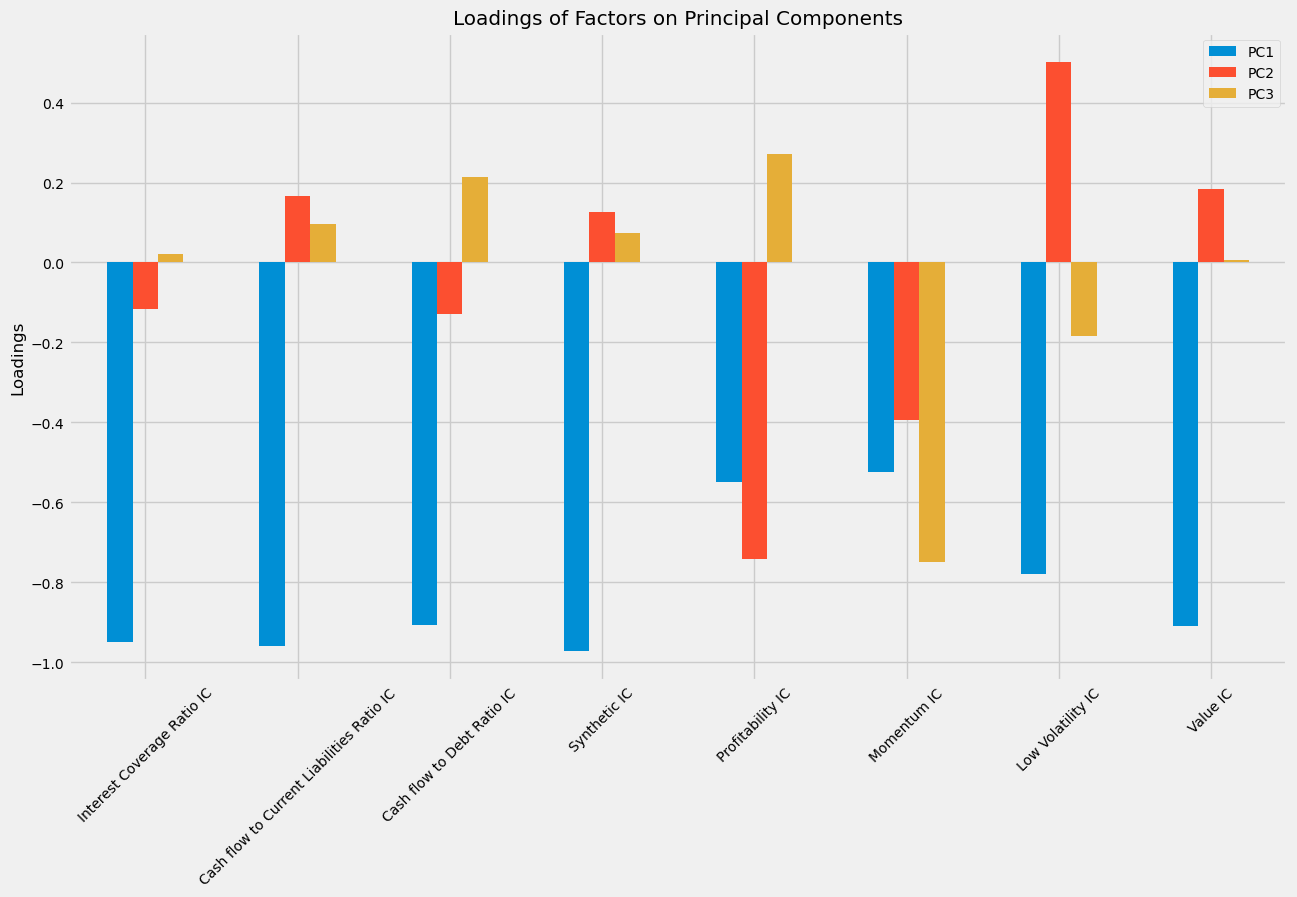

In [36]:

# Plot loadings for first three principal components
loading_df[['PC1', 'PC2', 'PC3']].plot(kind='bar', figsize=(14, 8))
plt.title('Loadings of Factors on Principal Components')

plt.ylabel('Loadings')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

### Second Concern:
These new ratios measure the ability of the company to generate enough cash flows to payoff interest on existing debt. Therefore, is it true that the predictive power of thesefactors is stronger when interest rates are higher?

Compare trendlines 12 month rolling mean of each IC from the new factors and interest rates (1YR and 10YR Yield to Maturity of US Gov.t Bonds)

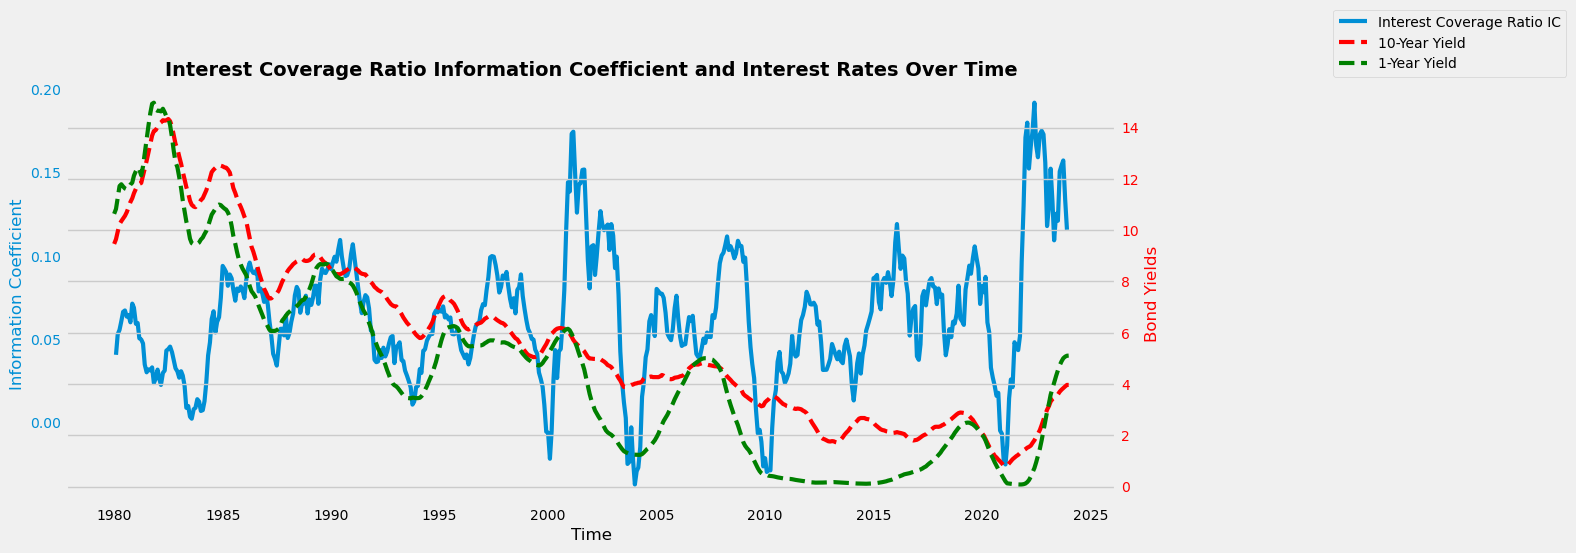

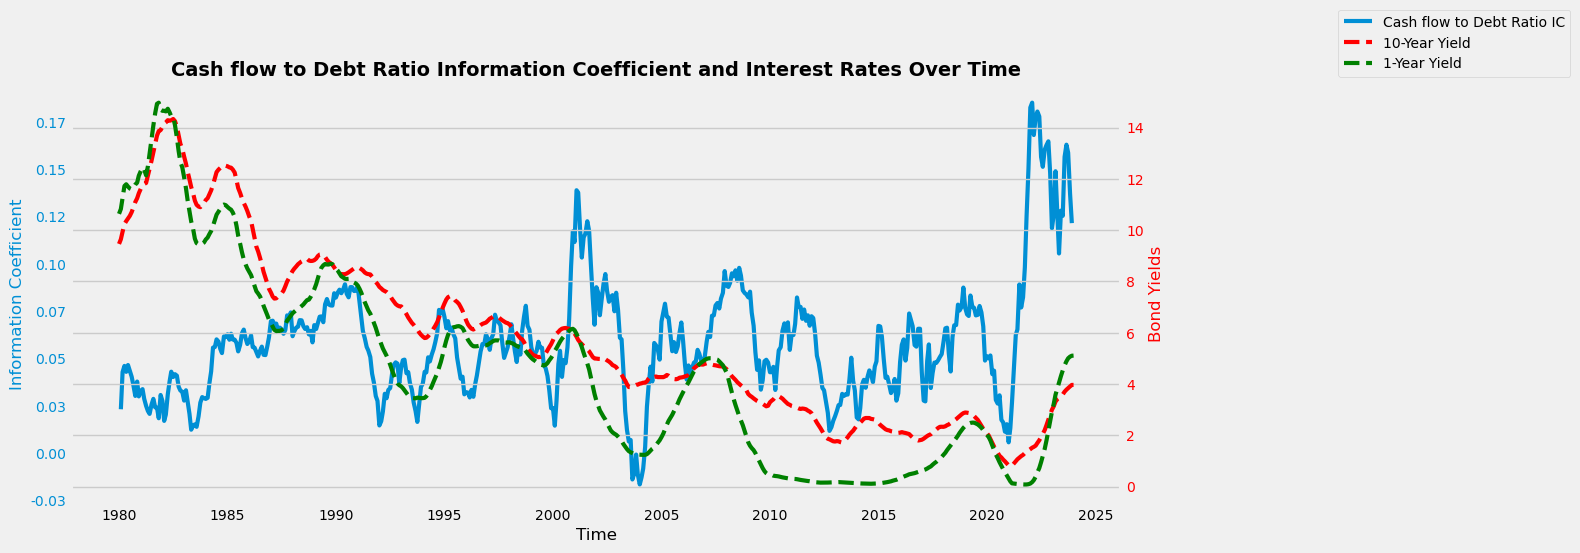

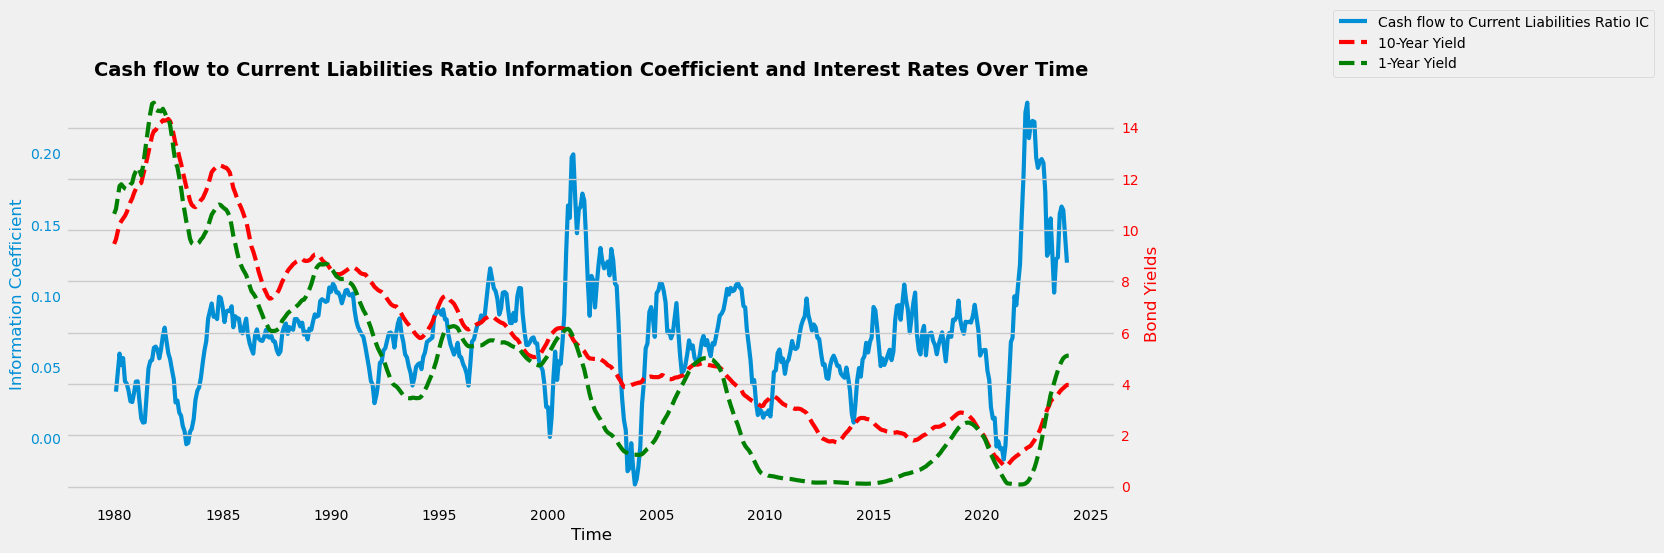

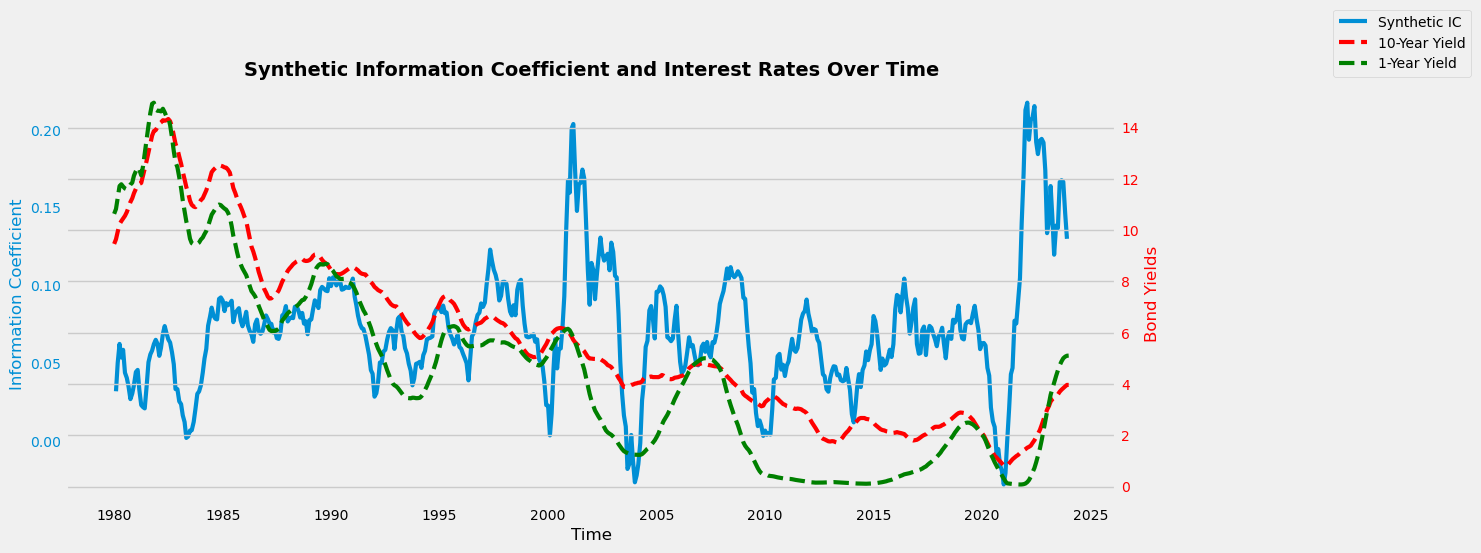

In [23]:
nf_ic = pd.DataFrame()
new_factors_list = [int_cov, cash_debt, cf_cl, synthetic]
for factor in new_factors_list:
    # ic = ap.ic_analysis(factor, prices, frequency='monthly')
    nf_ic[f'{factor.name}'] = ic(factor, prices, frequency='monthly')


win = 12


for col in nf_ic.columns:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax1.plot(nf_ic[col].rolling(window=win).mean(), label=f'{col} IC')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Information Coefficient', color='#008fd5')
    ax1.tick_params('y', colors='#008fd5')

    ax1.grid(False)

    # Create a second y-axis
    ax2 = ax1.twinx()

    # Plot 10-year and 1-year bond yields on the second y-axis, using th
    ax2.plot(int_rates['10YTR'].rolling(window=win).mean(), 'r--', label='10-Year Yield')
    ax2.plot(int_rates['1YTR'].rolling(window=win).mean(), 'g--', label='1-Year Yield')
    ax2.set_ylabel('Bond Yields', color='r')
    ax2.tick_params('y', colors='r')
    ax2.grid(True)

    line1, label1 = ax1.get_legend_handles_labels()
    line2, label2 = ax2.get_legend_handles_labels()
    ax1.legend(line1 + line2, label1 + label2, loc='lower left', bbox_to_anchor=(1.2, 1))
    ax1.tick_params(axis='y', which='both', labelsize=10)
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))

    # Adjust the spacing between subplots
    plt.subplots_adjust(left=0.1, bottom=0.2, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

    # Display the plot
    # Add a title to the graph
    plt.title(f'{col} Information Coefficient and Interest Rates Over Time', fontsize=14, fontweight='bold')

    # Adjust subplot to fit the legend
    plt.subplots_adjust(right=0.8)

    # Display the plot
    plt.show()

#Using 12 month moving average to :smooth out fluctuations or noise in time series data, making it easier to identify the underlying trend or pattern, better visualization and interpretation


# **5. Machine Learning**

Build and assess the predictive power of a decision tree with the following:

- Target Variable: the tree should try to predict if the next month return will be positive or negative.
- Max depth of 3
- New factor and old factor data

Find if the three new factors:
- Significantly affect how the decision tree predicts future performance.
- Increase the out of sample (OOS) forecasting accuracy of the model.
     

To begin, we organise the data into dataframes we can use.

In [24]:
#Calculate the future returns
fut_ret = np.log(prices.groupby('id').shift(-1) / prices).rename('fut_ret')

#Combine all the signals and future returns into a single dataframe
fd = pd.concat([int_cov, cf_cl, cash_debt, epq, mom12, gp, tvol, fut_ret], axis=1)

#Remove NAN values from the data
fd.dropna(inplace=True)

Using standard practice we rename our variables so that `X` contains all the features (a.k.a. information signals) and `y` contains the outcome variable.

With our outcome variable we define a 'good' return as one that is positive (i.e. greater than zero).

In [25]:
#In X we store the information signals by storing all the columns excluding the last
X = fd.iloc[:,0:-1]

#In y we store the future returns, using the name of the column
y = fd['fut_ret']>0

To ensure we can evaluate our model on data that is not used for model training, we will partition the datasets chronologically into training and testing sets.

In [26]:
X_train = X.loc[pd.IndexSlice[:, '1996-07-31':'2006-12-31'],:]
X_test = X.loc[pd.IndexSlice[:, '2007-01-01':'2023-12-31'],:]

y_train = y.loc[pd.IndexSlice[:, '1996-07-31':'2006-12-31']]
y_test = y.loc[pd.IndexSlice[:, '2007-01-01':'2023-12-31']]

Instantiate the decision tree, specify the depth parameter and fit the model using the training data we partitioned above.

In [27]:
#Instantiate the tree and specify the depth parameter
clf = tree.DecisionTreeClassifier(max_depth=3)

# Fit the model using the training data
clf.fit(X_train, y_train)

clf

DecisionTreeClassifier(max_depth=3)

Plot the decision tree:

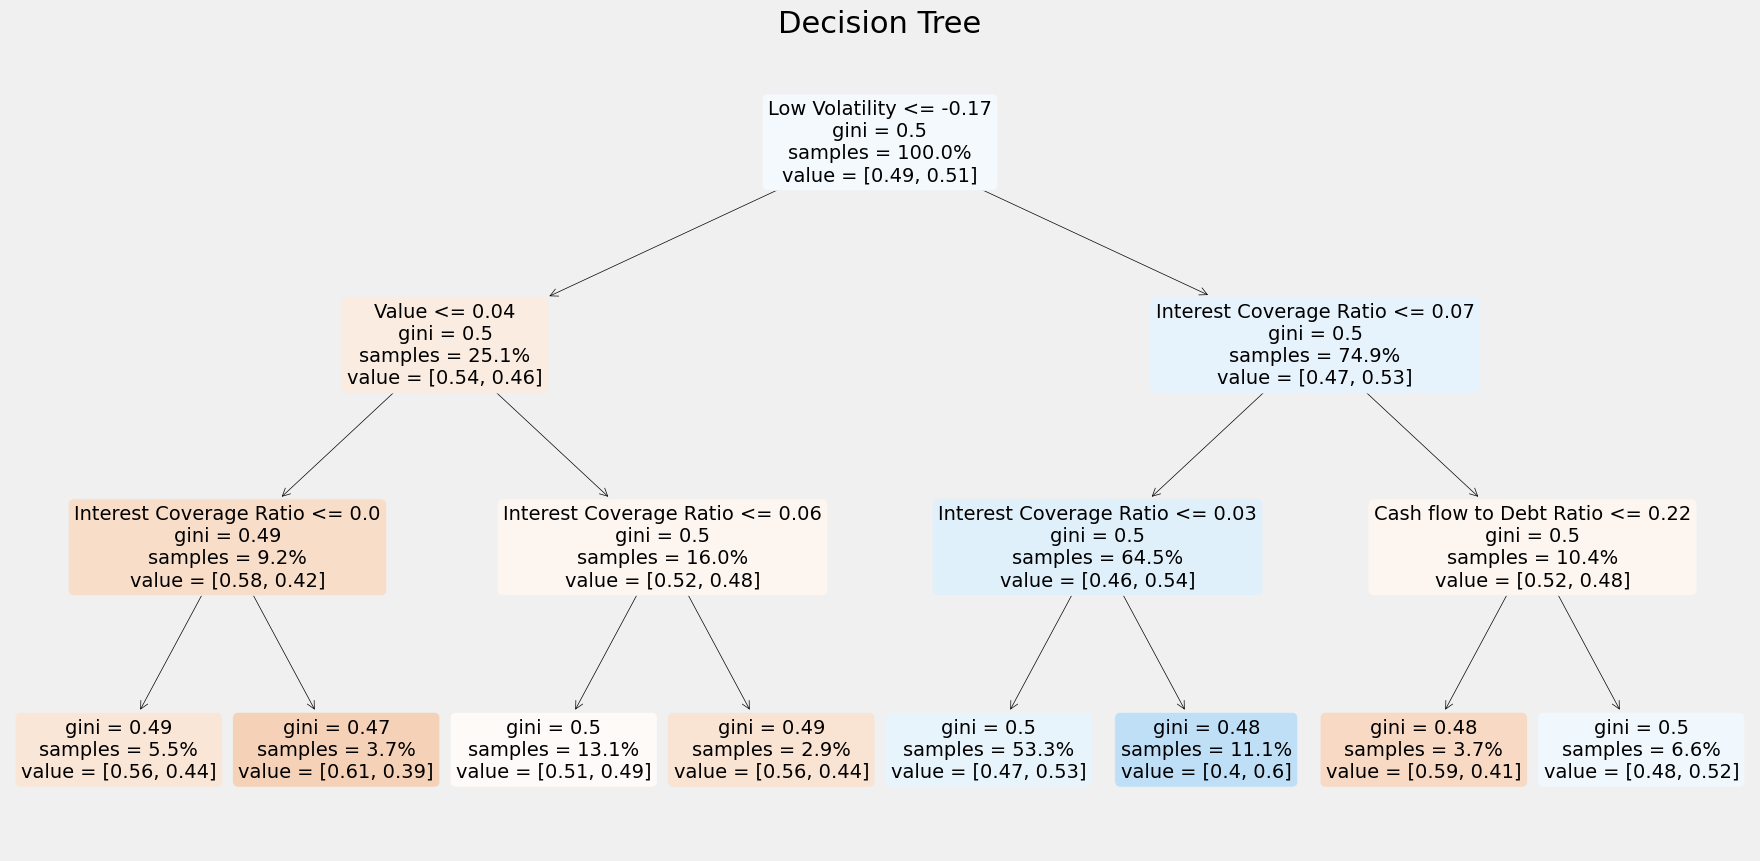

In [28]:
# Set the figure size
plt.figure(figsize=(20, 10))

# Plot the decision tree
tree.plot_tree(clf, 
               fontsize=14, 
               feature_names=X.columns.to_list(), 
               filled=True, 
               proportion=True,
               rounded=True,
               precision=2)

# Add a title to the plot
plt.title("Decision Tree", fontsize=22)

# Save the figure
plt.savefig('decision_tree.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [29]:
features = pd.DataFrame(clf.feature_importances_, columns=['Feature Importance'], index=X.columns)

We use a pie chart to visualise the feature importance.

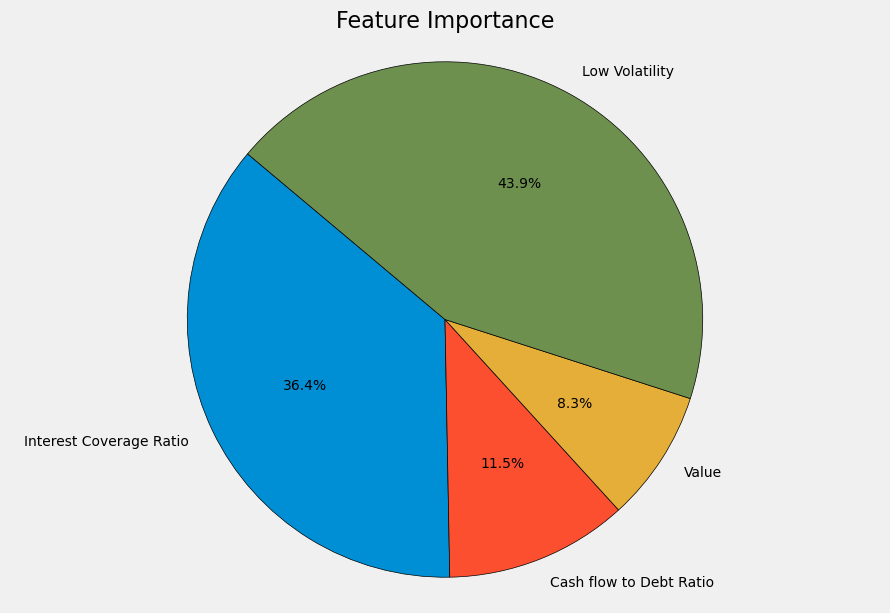

In [30]:
#Filter out features with zero importance
features = features[features['Feature Importance'] > 0]

#Create a pie chart
fig, ax = plt.subplots(figsize=(10, 7))
ax.pie(features['Feature Importance'], 
       labels=features.index, 
       autopct='%1.1f%%', 
       startangle=140, 
       wedgeprops={'edgecolor': 'black'})  # Adding black border to wedges
ax.set_title('Feature Importance', fontsize=16)

#Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')  

plt.show()

#Save the figure
fig.savefig('feature_importance_pie_chart.png', dpi=300, bbox_inches='tight')

In [31]:
#In-sample predictions
y_train_pred = clf.predict(X_train)

#Out-of-sample predictions
y_test_pred = clf.predict(X_test)

#Measure the accuracy
is_accuracy = metrics.accuracy_score(y_train, y_train_pred)
os_accuracy = metrics.accuracy_score(y_test, y_test_pred)

#Calculate the forecasting accuracy using 10-Folds Cross Validation
scores = cross_val_score(clf, X, y, cv=10)
print(f'10-Folds Cross Validation Average Accuracy: {round(scores.mean(), 5)}')


10-Folds Cross Validation Average Accuracy: 0.53892


Analyse the predicive power of the machine learning model

Average IC: 0.039 

Percentage of Positive Periods: 0.704 

Percentage of Negative Periods: 0.296 

T-Stat: 6.787 P-Value: 0.0 



<Axes: title={'center': 'Predicitve Power of the Machine Learning Model'}, xlabel='date'>

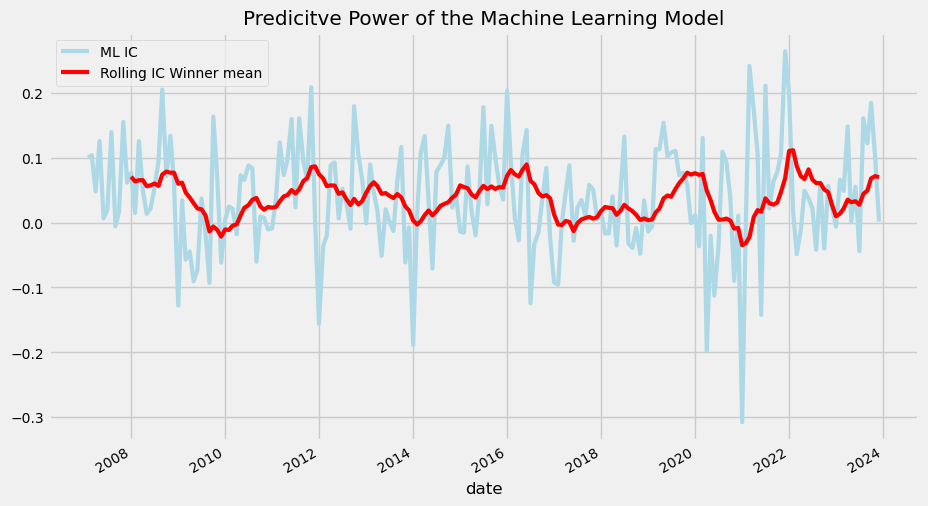

In [33]:
#Define the prediction
pred = pd.Series(y_test_pred.astype('int64'), index = X_test.index).rename('Winner')

dt_ic = ap.ic_analysis(pred, prices, frequency='monthly')

avg_dt_ic = dt_ic.rolling(12).mean().rename('Rolling IC Winner mean')
dt_df = dt_ic.rename('ML IC').to_frame().join(avg_dt_ic)

dt_df.plot(figsize=(10, 6),
         color={'ML IC':'lightblue', 'Rolling IC Winner mean':'red'},
         title='Predicitve Power of the Machine Learning Model')

Build a baseline model to compare out-of-sample forecasting accuracy

In [34]:
#Calculate the future returns
fut_ret2 = np.log(prices.groupby('id').shift(-1) / prices).rename('fut_ret')

#Combine all the signals and future returns into a single dataframe
fd2 = pd.concat([epq, mom12, gp, tvol, fut_ret2], axis=1)

#Remove NAN values from the data
fd2.dropna(inplace=True)

#In X the information signals from the dataframe
X2 = fd2.iloc[:,0:-1]
y2 = fd2['fut_ret']>0

#Split the test and train datasets using pandas 'Index Slice'
X_train2 = X2.loc[pd.IndexSlice[:, '1996-07-31':'2006-12-31'],:]
X_test2 = X2.loc[pd.IndexSlice[:, '2007-01-01':'2023-12-31'],:]

y_train2 = y2.loc[pd.IndexSlice[:, '1996-07-31':'2006-12-31']]
y_test2 = y2.loc[pd.IndexSlice[:, '2007-01-01':'2023-12-31']]


#Instantiate the tree and specify the depth parameter
clf2 = tree.DecisionTreeClassifier(max_depth=3)

#Fit the model using the training data
clf2.fit(X_train2, y_train2)

#Measure the OOS forecasting accuracy

scores2 = cross_val_score(clf2, X2, y2, cv=10)
print(f'10-Folds Cross Validation Average Accuracy of the baseline model: {round(scores2.mean(), 5)}')

10-Folds Cross Validation Average Accuracy of the baseline model: 0.53951
